In [2]:
import numpy as np 
import cPickle as pkl
from matplotlib import pyplot as plt
import pandas as pd

import theano_time_corex
import linearcorex

import sklearn.covariance as skcov
from sklearn.decomposition import FactorAnalysis, PCA

from generate_data import generate_nglf_from_matrix, generate_nglf_from_model

from sklearn.preprocessing import StandardScaler

import sys

import vis_utils
import metric_utils

# Load Data

In [31]:
with open('../data/EOD_day.pkl', 'rb') as f:
    day_df = pd.DataFrame(pkl.load(f))

print("Data.shape = {}".format(day_df.shape))

df_2010 = day_df[day_df.index >= '2010-01-01']
df_2010 = df_2010[df_2010.index <= '2010-04-01']
# df_2010 = df_2010[['AAPL', 'MSFT', 'AMZN', 'INTC', 'BA', 'FDX']]
df_2010 = df_2010.loc[:, list(np.max(np.array(df_2010), axis=0)<1)]

cols = list(df_2010.columns)
random.shuffle(cols)

nv = 100

df_2010 = df_2010[cols[:nv]]

X = []
Y = []

window = 8

for i in range(window, len(df_2010)-window):
    start = i - window
    end = i + window + 1
    part = np.array(df_2010[start : end])
    perm = range(2*window + 1)
    random.shuffle(perm)
    X.append(part[perm[:window], :])
    Y.append(part[perm[window:], :])

print [len(x) for x in X]
print [len(y) for y in Y]

nt = len(X)

Data.shape = (4277, 5038)
[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]


In [44]:
for i in range(len(X)):
    scaler = StandardScaler()
    X[i] = scaler.fit_transform(X[i]) + np.random.multivariate_normal(np.zeros((nv,)), 0.01 * np.eye(nv), size=(len(X[i]),))
    Y[i] = scaler.transform(Y[i]) + np.random.multivariate_normal(np.zeros((nv,)), 0.01 * np.eye(nv), size=(len(Y[i]),))

## check ill conditioned

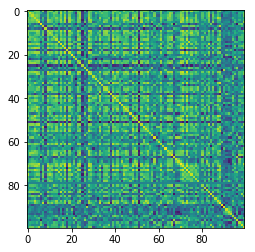

In [49]:
plt.imshow(np.cov(X[0].T))
plt.show()

In [46]:
glasso_covs = []
for x in X:
    glasso_est = skcov.GraphLasso(mode='lars', alpha=0.01)
    glasso_est.fit(x)
    glasso_covs.append(glasso_est.covariance_)

OverflowError: long int too large to convert to float

# Simple baseline, diagonal covariance

In [50]:
diag_covs = []
for x in X:
    diag_covs.append(np.diag(np.var(x, axis=0)))

#### This graph shows how well the covariance ESTIMATE of timestep t models the test data at timestep t+1. 

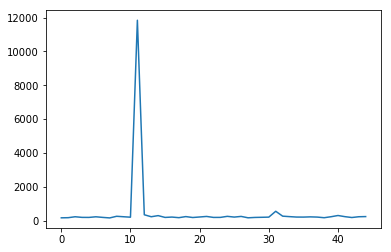

NLL = 483.599063287


In [51]:
nll = [-np.mean([multivariate_normal.logpdf(sx, cov=diag_covs[t], allow_singular=False) for sx in x]) for x,t in zip(Y[1:], range(nt-1))]
plt.plot(nll)
plt.show()
print "NLL = {}".format(np.mean(nll))

#### Negative log-likelihood of cov. estimate on each timestep. We report the sum of negative log-likelihood over timesteps.

In [52]:
nll = [-np.mean([multivariate_normal.logpdf(sx, cov=diag_covs[t], allow_singular=False) for sx in x]) for x,t in zip(Y, range(nt))]
print "NLL = {}".format(np.mean(nll))

NLL = 214.825716214


# Learn independent linear corexes on each timestep

In [53]:
cs = []
for x in X:
    c = linearcorex.Corex(n_hidden=8*2,
                    max_iter=400,
                    anneal=True)
    c.fit(x)
    cs.append(c)
    
print sum([c.tc for c in cs])

5520.46346283


In [54]:
corex_covs_not = [c.get_covariance() for c in cs]

In [56]:
corex_covs = [skcov.shrunk_covariance(c, shrinkage=0) for c in corex_covs_not]

#### This graph shows how well the covariance ESTIMATE of timestep t models the test data at timestep t+1. We would like to see a peak at the middle timestep, but as we don't have many training samples there is no clear peak. We can say that the model overfits a lot at each timestep.

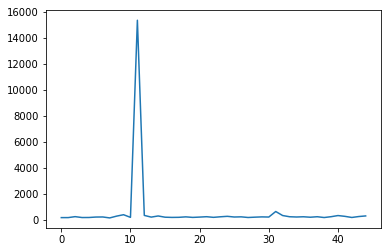

NLL = 557.426585168


In [57]:
nll = [-np.mean([multivariate_normal.logpdf(sx, cov=corex_covs[t], allow_singular=False) for sx in x]) for x,t in zip(Y[1:], range(nt-1))]
plt.plot(nll)
plt.show()
print "NLL = {}".format(np.mean(nll))

#### Negative log-likelihood of cov. estimate on each timestep. We report the sum of negative log-likelihood over timesteps.

In [58]:
nll = [-np.mean([multivariate_normal.logpdf(sx, cov=corex_covs[t], allow_singular=False) for sx in x]) for x,t in zip(Y, range(nt))]
print "NLL = {}".format(np.mean(nll))

NLL = 241.666589169


# no regularization

In [117]:
c0 = theano_time_corex.TimeCorexW(nt=nt,
                                nv=nv,
                                n_hidden=8*2,
                                max_iter=500,
                                verbose=False,
                                anneal=True)
c0.fit(X)
print sum(c0.tc)

Annealing iteration finished, time = 10.049902916
Annealing iteration finished, time = 10.0089151859
Annealing iteration finished, time = 10.0209679604
Annealing iteration finished, time = 10.0076949596
Annealing iteration finished, time = 10.0337409973
Annealing iteration finished, time = 10.0314679146
Annealing iteration finished, time = 10.0574989319
5240.54051226


In [118]:
c0_covs_not = c0.get_covariance()

In [119]:
c0_covs = [skcov.shrunk_covariance(c, shrinkage=0.0) for c in c0_covs_not]

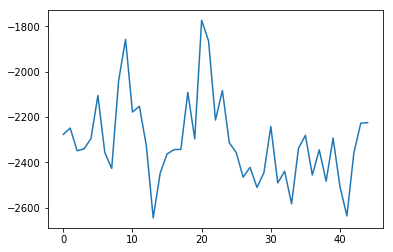

NLL = -103832.775743


In [120]:
nll = [-np.sum([multivariate_normal.logpdf(sx, cov=c0_covs[t], allow_singular=False) for sx in x]) for x,t in zip(Y[1:], range(nt-1))]
plt.plot(nll)
plt.show()
print "NLL = {}".format(sum(nll))

In [121]:
nll = [-np.mean([multivariate_normal.logpdf(sx, cov=c0_covs[t], allow_singular=False) for sx in x]) for x,t in zip(Y, range(nt))]
print "NLL = {}".format(np.mean(nll))

NLL = -208.455662965


# L1 regularization on the difference of neighbouring covariance estimates

In [139]:
csig = theano_time_corex.TimeCorexSigma(nt=nt,
                                        nv=nv,
                                        n_hidden=8*2,
                                        max_iter=400,
                                        verbose=False,
                                        anneal=True,
                                        l1=1)
csig.fit(X)
print sum(csig.tc)

Annealing iteration finished, time = 21.5613930225
Annealing iteration finished, time = 22.4666340351
Annealing iteration finished, time = 20.5448009968
Annealing iteration finished, time = 21.0534131527
Annealing iteration finished, time = 22.7753741741
Annealing iteration finished, time = 19.3384010792
Annealing iteration finished, time = 23.5306589603
1436.33244606


In [140]:
csig_covs = csig.get_covariance()

#### This graph shows how well the covariance ESTIMATE of timestep t models the test data at timestep t+1. As we regularize the model we have less overfitting and the system is able to find the change at the middle.

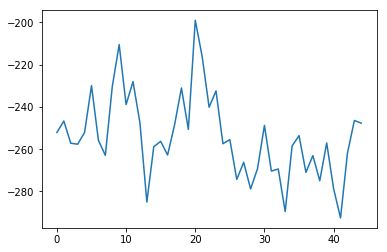

NLL = -254.112726756


In [141]:
nll = [-np.mean([multivariate_normal.logpdf(sx, cov=csig_covs[t], allow_singular=False) for sx in x]) for x,t in zip(Y[1:], range(nt-1))]
plt.plot(nll)
plt.show()
print "NLL = {}".format(np.mean(nll))

#### Negative log-likelihood of cov. estimate on each timestep. We report the sum of negative log-likelihood over timesteps.

In [142]:
nll = [-np.mean([multivariate_normal.logpdf(sx, cov=csig_covs[t], allow_singular=False) for sx in x]) for x,t in zip(Y, range(nt))]
print "NLL = {}".format(np.mean(nll))

NLL = -215.526950804


# Other methods of covariance estimation

## Ledoit-Wolf Estimation

In [126]:
lw_covs = []
for x in X:
    lw_est = skcov.LedoitWolf()
    lw_est.fit(x)
    lw_covs.append(lw_est.covariance_)

#### This graph shows how well the covariance ESTIMATE of timestep t models the test data at timestep t+1. 

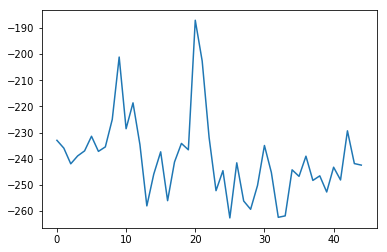

NLL = -239.661854291


In [127]:
nll = [-np.mean([multivariate_normal.logpdf(sx, cov=lw_covs[t], allow_singular=False) for sx in x]) for x,t in zip(Y[1:], range(nt-1))]
plt.plot(nll)
plt.show()
print "NLL = {}".format(np.mean(nll))

#### Negative log-likelihood of cov. estimate on each timestep. We report the sum of negative log-likelihood over timesteps.

In [128]:
nll = [-np.mean([multivariate_normal.logpdf(sx, cov=lw_covs[t], allow_singular=False) for sx in x]) for x,t in zip(Y, range(nt))]
print "NLL = {}".format(np.mean(nll))

NLL = -214.102971853


## Oracle Approximating Shrinkage

In [129]:
oas_covs = []
for x in X:
    oas_est = skcov.OAS()
    oas_est.fit(x)
    oas_covs.append(oas_est.covariance_)

#### This graph shows how well the covariance ESTIMATE of timestep t models the test data at timestep t+1. 

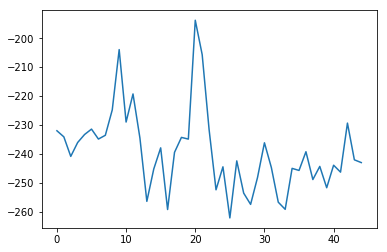

NLL = -239.196291299


In [130]:
nll = [-np.mean([multivariate_normal.logpdf(sx, cov=oas_covs[t], allow_singular=False) for sx in x]) for x,t in zip(Y[1:], range(nt-1))]
plt.plot(nll)
plt.show()
print "NLL = {}".format(np.mean(nll))

#### Negative log-likelihood of cov. estimate on each timestep. We report the sum of negative log-likelihood over timesteps.

In [131]:
nll = [-np.mean([multivariate_normal.logpdf(sx, cov=oas_covs[t], allow_singular=False) for sx in x]) for x,t in zip(Y, range(nt))]
print "NLL = {}".format(np.mean(nll))

NLL = -216.474010656


## Graphical LASSO

In [132]:
glasso_covs = []
for x in X:
    glasso_est = skcov.GraphLasso(mode='lars')
    glasso_est.fit(x)
    glasso_covs.append(glasso_est.covariance_)

#### This graph shows how well the covariance ESTIMATE of timestep t models the test data at timestep t+1. 

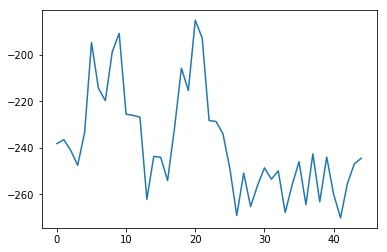

NLL = -238.263243287


In [133]:
nll = [-np.mean([multivariate_normal.logpdf(sx, cov=glasso_covs[t], allow_singular=False) for sx in x]) for x,t in zip(Y[1:], range(nt-1))]
plt.plot(nll)
plt.show()
print "NLL = {}".format(np.mean(nll))

#### Negative log-likelihood of cov. estimate on each timestep. We report the sum of negative log-likelihood over timesteps.

In [134]:
nll = [-np.mean([multivariate_normal.logpdf(sx, cov=glasso_covs[t], allow_singular=False) for sx in x]) for x,t in zip(Y, range(nt))]
print "NLL = {}".format(np.mean(nll))

NLL = -216.773266193


# Summary of the results

1) Negative log-likelihood results:

| Model | NLL |  
|:------|----:|  
| independent corexes              | 105237.22 |  
| regularized corex                |  61546.79 |  
| shrinkage estimator (coef = 0.1) | 162136.32 |
| Ledoit-Wolf                      | 52950.41  |
| OAS                              | 49325.46  |
| GLASSO                           | ill cond. |
| Emprical covariance              | ill cond. |

2) Without regularization the system doesn't detect the global change at the middle timestep, but with regularization it finds.